In [74]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [75]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

In [76]:
# 각 유저들이 몇 개의 영화를 봤는지
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [77]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [78]:
user_length.min(), user_length.max()

(20, 2314)

In [79]:
user_length.quantile(0.999)

1343.181000000005

In [80]:
# 2314개의 영화를 본 유저
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [81]:
# 유저가 본 영화 수 기준 하위 99.9%까지의 분포 누적합
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

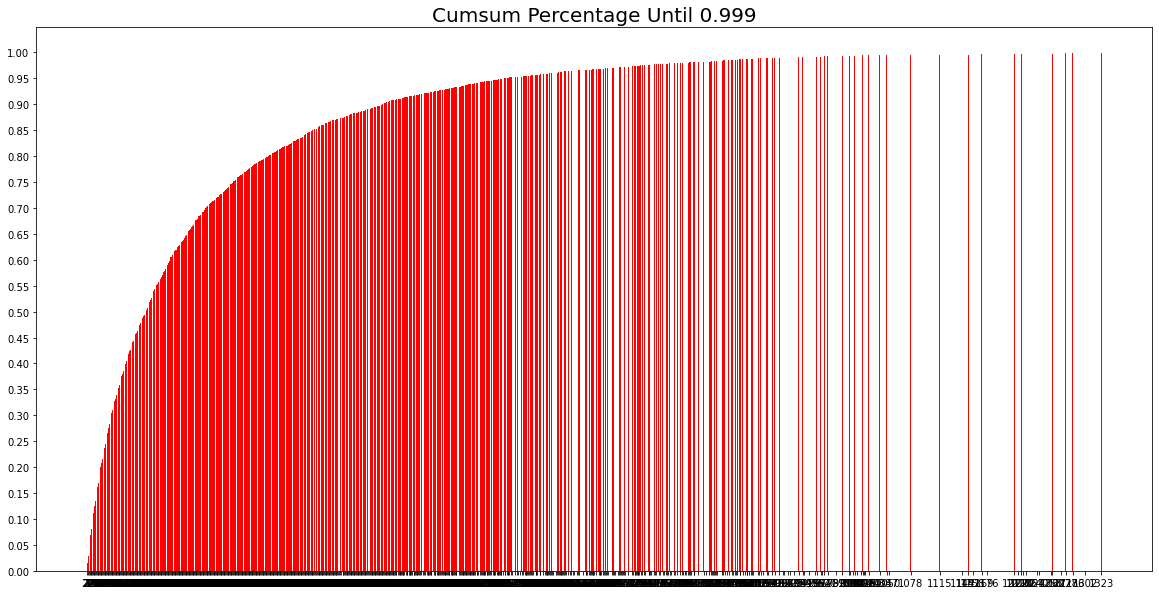

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [83]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [84]:
x = latest-oldest
print(x//86400) # 측정한 일 수
print(x//2592000) # 측정한 월 수

1038
34


In [85]:
type(latest)

numpy.int64

In [86]:
# # 최근 2년 동안 본 영화만 고려한다.
# year_ago = latest - 2*31536000     # 최종 날짜로부터 2년 이전 날짜를 구한다.  
# data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

### DataCleansing

In [87]:
# short_user을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 user가 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [88]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### Train/Valid/Test split

In [89]:
tr, test = train_test_split(data, test_size = 0.2, shuffle = False)
tr, val = train_test_split(data, test_size = 0.16, shuffle = False)

In [90]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [91]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 839673
	 Users: 5047
	 Items: 3416
	 First Time : 962496006
	 Last Time : 1046454590

* valid Set Stats Info
	 Events: 159938
	 Users: 994
	 Items: 3287
	 First Time : 956703932
	 Last Time : 1046444711

* test Set Stats Info
	 Events: 199923
	 Users: 1246
	 Items: 3329
	 First Time : 956703932
	 Last Time : 1046454590



In [92]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [93]:
# 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

In [94]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [95]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [96]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 838589, 839457, 839673], dtype=int32)

In [97]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 5044, 5045, 5046])

In [98]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 유저 Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 유저 ndex를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 유저가 시작되는 위치인데 start와 한 칸 차이난다는 것은 user가 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 유저 개수만큼 새로운 유저를 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 유저가 마지막 유저 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 유저 대신 새로운 유저의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 유저의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [99]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [100]:
iter_ex = iter(tr_data_loader)

In [101]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [103]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [104]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [105]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20)

In [106]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [107]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [108]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.6] 

	 - Recall@20 epoch 1: 0.177748
	 - MRR@20    epoch 1: 0.044434



Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.0117, train_loss=7.47] 

	 - Recall@20 epoch 2: 0.268908
	 - MRR@20    epoch 2: 0.070528



Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.0117, train_loss=7.42] 

	 - Recall@20 epoch 3: 0.294544
	 - MRR@20    epoch 3: 0.080414



Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.51] 

	 - Recall@20 epoch 4: 0.308256
	 - MRR@20    epoch 4: 0.085849



Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.0234, train_loss=7.39] 

	 - Recall@20 epoch 5: 0.315516
	 - MRR@20    epoch 5: 0.089737



Train:   0%|          | 0/3260 [00:00<?, ?it/s, accuracy=0.0234, train_loss=7.38] 

	 - Recall@20 epoch 6: 0.319058
	 - MRR@20    epoch 6: 0.092072



Evaluation:  71%|███████   | 439/620 [10:10<04:11,  1.39s/it]

	 - Recall@20 epoch 7: 0.320837
	 - MRR@20    epoch 7: 0.093574



In [109]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  77%|███████▋  | 595/776 [13:49<04:12,  1.39s/it]

	 - Recall@20: 0.318783
	 - MRR@20: 0.092899



## 회고


- 데이터전처리 과정에서 최근 1년간 본 영화만 추릴려고 했는데, 데이터 수가 많이 작아져서 결국 모든 데이터를 다 사용했다.
- 데이터가 적어서 rating만큼 곱해서 늘리려고 했는데 어떻게 해야할지 몰라서 못 했다.  
- 처음에 배치 사이즈를 2048로 하니깐 오류가 나서 512로 줄였다.
- train loss는 6.61에서 5.71로 점차적으로 감소함을 확인했다.

1. batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20
     - Recall@20: 0.318449
	 - MRR@20: 0.090790
     
     
2. drop_rate를 0.5로 늘려보았다.   
   batch_size=512, hsz=50, drop_rate=0.5, lr=0.001, epochs=7, k=20
     - Recall@20: 0.298525
	 - MRR@20: 0.080337  
   -> recall, mrr 값 둘 다 떨어졌다.
   
   
3. batch_size를 256으로 줄여보았다.  
   batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=7, k=20
     - Recall@20: 0.318783
	 - MRR@20: 0.092899
    -> recall, mrr 값 둘 다 미세하게 올랐다.

   
 #### 중간 결론 : 하이퍼파라미터를 조정해본 결과, drop_rate는 0.1일 때가 0.5일 때보다 좋으며, batch_size는 512일 때보다 256일때가 좋다.
 
 4. 세션 정의
 
 -> 0.99로 해보려고 했으나, 시간부족으로 하지 못했다. 중단 되기 전까지는 0.999보다 성능이 좋았다.
 
 5. 모델 변경(LSTM)
 
 -> 계속 해보려고 했으나, 오류가 많이 떠서 포기했다.